### Import packages

In [1]:
import pandas as pd
import os
import torch as th
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from scripts.utils import *
from scripts.visualizations import *
from config import *
from datetime import datetime, timedelta

### Hyperparameters

In [2]:
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000
BATCH_SIZE = 32
TARGET_UPDATE_INTERVAL = 100
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY_RATE = 0.0005
N_EPISODES = 300            # number of episodes PER TRAINING SCENARIO
MAX_TIMESTEPS = 500         # maximum number of timesteps per episode (not relevant here)
TRAINING_FOLDERS_PATH = 'Data/Training'

#print all folders in the training folder
training_folders = []
for folder in os.listdir(TRAINING_FOLDERS_PATH):
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder)):
        training_folders.append(folder)

num_days_trained_on = N_EPISODES * len(training_folders)
print(f'Training on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)')

model_name = 'dqn_' + str(num_days_trained_on) + "d_" + str(len(training_folders)) + "u"
print('Model name:', model_name)
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = 'Models/' + model_name + '-' + model_version + '.zip'

print('Model will be saved to:', MODEL_SAVE_PATH)

Training on 3000 days of data (10 unique scenarios)
Model name: dqn_3000d_10u
checking file: dqn_3000d_20240914-1.zip
Model will be saved to: Models/dqn_3000d_10u-1.zip


# Reinforcement Learning

## Environment

In [3]:
from environment import AircraftDisruptionEnv

## Loading Scenario

In [4]:
def load_scenario_data(scenario_folder):
    file_keys = ['aircraft', 'airports', 'alt_aircraft', 'alt_airports', 'alt_flights', 'config', 'dist', 'flights', 'itineraries', 'position', 'rotations']
    file_paths = {key: os.path.join(scenario_folder, f"{key}.csv") for key in file_keys}

    data_dict = {}
    file_parsing_functions = {
        'config': FileParsers.parse_config,
        'airports': FileParsers.parse_airports,
        'dist': FileParsers.parse_dist,
        'flights': FileParsers.parse_flights,
        'aircraft': FileParsers.parse_aircraft,
        'rotations': FileParsers.parse_rotations,
        'itineraries': FileParsers.parse_itineraries,
        'position': FileParsers.parse_position,
        'alt_flights': FileParsers.parse_alt_flights,
        'alt_aircraft': FileParsers.parse_alt_aircraft,
        'alt_airports': FileParsers.parse_alt_airports
    }

    # Iterate over each file and process it using the correct parsing function
    for file_type, file_path in file_paths.items():
        file_lines = read_csv_with_comments(file_path)
        if file_lines:
            parse_function = file_parsing_functions.get(file_type)
            if parse_function:
                parsed_data = parse_function(file_lines)
                data_dict[file_type] = parsed_data
            else:
                print(f"No parser available for file type: {file_type}")
        else:
            data_dict[file_type] = None

    return data_dict


## Training

In [5]:
# Storing the reward for each episode per scenario
rewards = []


def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [os.path.join(TRAINING_FOLDERS_PATH, folder) for folder in os.listdir(TRAINING_FOLDERS_PATH) if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))]
    
    total_timesteps = 0
    epsilon = EPSILON_START

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)

            # Extract necessary data for the environment
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Initialize the environment with the current scenario
            env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
            env = DummyVecEnv([lambda: env])

            # Initialize the DQN model **after** setting the environment
            model = DQN(
                policy="MlpPolicy",
                env=env,  # Pass the environment here
                learning_rate=LEARNING_RATE,
                gamma=GAMMA,
                buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE,
                target_update_interval=TARGET_UPDATE_INTERVAL,
                verbose=1
            )

            # Reset the environment
            obs = env.reset()

            done = False
            total_reward = 0
            timesteps = 0

            while not done and timesteps < MAX_TIMESTEPS:
                # Perform an action using the current policy (or epsilon-greedy)
                action = model.predict(obs, deterministic=False)[0]

                # Step the environment
                obs, reward, done, info = env.step(action)

                # Accumulate the reward
                total_reward += reward

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon - EPSILON_DECAY_RATE)

                timesteps += 1
                total_timesteps += 1

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))
            
            print(f"Episode {episode}, Scenario {scenario_folder}, Total Reward: {total_reward}")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)

# Run the training process
train_dqn_agent()


Using cpu device


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


Episode 0, Scenario Data/Training/Scenario_03, Total Reward: [-395.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_04, Total Reward: [-2605.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_05, Total Reward: [-72000.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_02, Total Reward: [8055.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_10, Total Reward: [4415.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_09, Total Reward: [-365.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_07, Total Reward: [-2440.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_01, Total Reward: [0.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_06, Total Reward: [-1675.]
Using cpu device
Episode 0, Scenario Data/Training/Scenario_08, Total Reward: [0.]
Using cpu device
Episode 1, Scenario Data/Training/Scenario_03, Total Reward: [-395.]
Using cpu device
Episode 1, Scenario Data/Training/Scenario_04, Total Re

3000


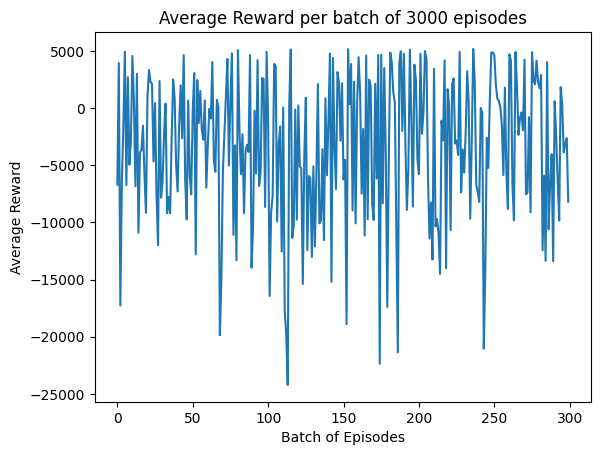

In [6]:
print(len(rewards))

avg_rewards = []

# avg_rewards contains N_EPISODES elements, each element is the average reward for a given iteration of the ten scenarios
for i in range(0, len(rewards), 10):
    avg_rewards.append(np.mean([reward for _, _, reward in rewards[i:i+10]]))
    
# Plot the average rewards over the episodes
plt.plot(range(N_EPISODES), avg_rewards)
plt.xlabel('Batch of Episodes')
plt.ylabel('Average Reward')
plt.title(f'Average Reward per batch of {num_days_trained_on} episodes')
plt.show()
